In [1258]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

#### Specifying the paths

In [1259]:
csv_path = Path(
    r"\\wsl.localhost\Ubuntu-24.04\home\user\OF\attempt_2\results\csv\results.csv"
)
figures_path = Path(
    r"\\wsl.localhost\Ubuntu-24.04\home\user\OF\attempt_2\results/figures"
)
figures_path.mkdir(exist_ok=True, parents=True)

#### Loading in data

In [1260]:
df = pd.read_csv(csv_path, parse_dates=["datetime"])
df["cl_cd"] = df["cl"] / df["cd"]
df["cl_cd_abs"] = (df["cl"] / df["cd"]).abs()
df["failed"] = (~df[["block_mesh", "check_mesh", "simple"]]).any(axis=1)
df_filtered = df.dropna(subset=["cl", "cd"]).copy()
df_filtered["moving_avg"] = df_filtered["cl_cd_abs"].rolling(window=30).mean()

#### Progress plot

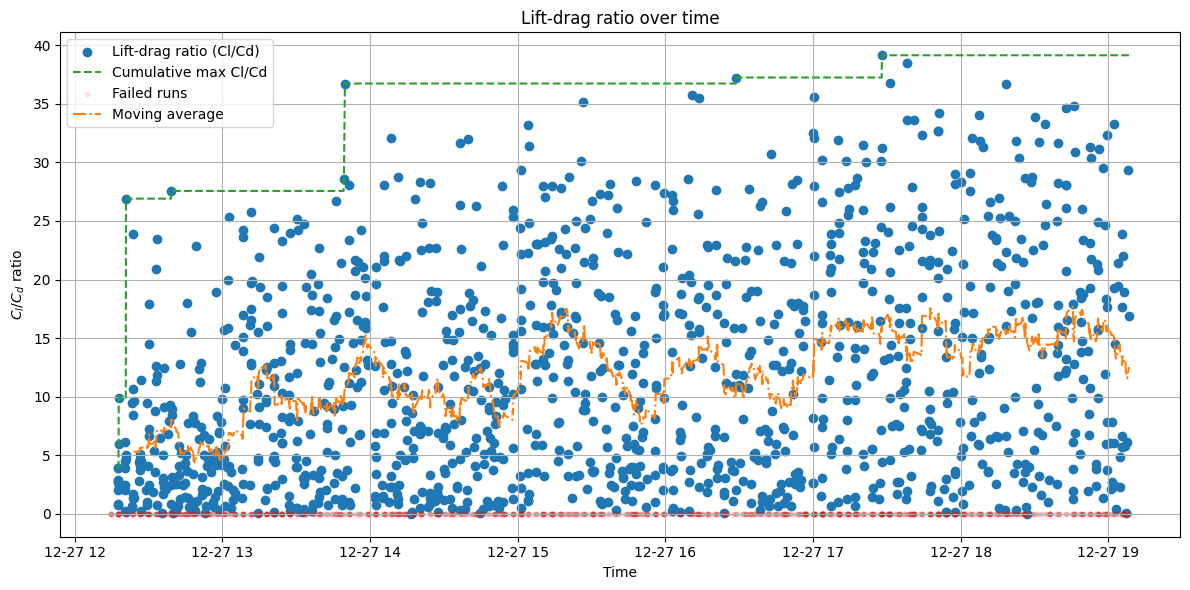

In [1269]:
plt.figure(figsize=(12, 6))
plt.scatter(
    df_filtered["datetime"],
    df_filtered["cl_cd_abs"],
    label="Lift-drag ratio (Cl/Cd)",
    marker="o",
    color="tab:blue",
)
plt.plot(
    df_filtered["datetime"],
    df_filtered["cl_cd_abs"].cummax(),
    label="Cumulative max Cl/Cd",
    linestyle="--",
    color="tab:green",
)
plt.scatter(
    df[df["failed"]]["datetime"],
    -df[df["failed"]]["failed"],
    s=10,
    color="tab:red",
    alpha=0.1,
    label="Failed runs",
)

plt.plot(
    df_filtered["datetime"],
    df_filtered["moving_avg"],
    label="Moving average",
    linestyle="-.",
    color="tab:orange",
)

plt.title("Lift-drag ratio over time")
plt.xlabel("Time")
plt.ylabel("$C_l/C_d$ ratio")

# Use a locator to reduce the density of x-ticks
# locator = mdates.HourLocator(interval=1)
# formatter = mdates.DateFormatter("%H:%M")
# plt.gca().xaxis.set_major_locator(locator)
# plt.gca().xaxis.set_major_formatter(formatter)

plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(
    "results/figures/27122024 - OpenFOAM - Lift-drag ratio over time.png", dpi=300
)
plt.show()

#### Attempts at model reduction

Mean Squared Error: 18.243168914738458
Mean Absolute Error: 2.989162240722794
Mean Percentage Error: 27.66%

Dummy Model Evaluation:
Mean Squared Error (Dummy): 123.45266431214534
Mean Absolute Error (Dummy): 8.659073418111676
Mean Percentage Error (Dummy): 69.99%


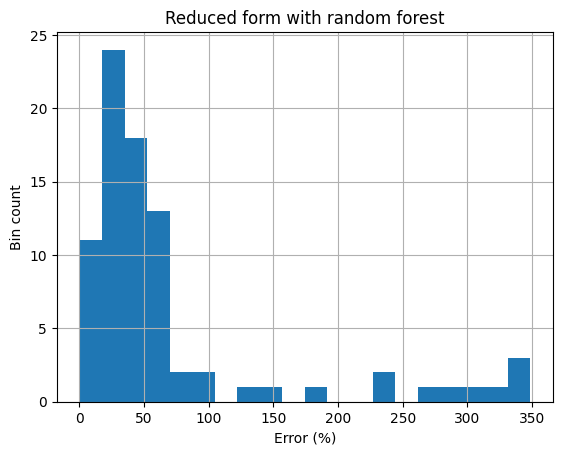

In [1267]:
df_subset = df_filtered[
    (df_filtered["cl_cd_abs"] > 5.0) & (df_filtered["cl_cd_abs"] < 30.0)
]

X = df_subset[["x0", "x1", "x2", "x3", "x4", "x5"]]
y = df_subset["cl_cd"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
percentage_error = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Percentage Error: {percentage_error:.2f}%")

# Dummy method: Mean baseline
y_dummy_pred = [y_train.mean()] * len(y_test)
mse_dummy = mean_squared_error(y_test, y_dummy_pred)
mae_dummy = mean_absolute_error(y_test, y_dummy_pred)
percentage_error_dummy = np.mean(np.abs((y_test - y_dummy_pred) / y_test)) * 100

print("\nDummy Model Evaluation:")
print(f"Mean Squared Error (Dummy): {mse_dummy}")
print(f"Mean Absolute Error (Dummy): {mae_dummy}")
print(f"Mean Percentage Error (Dummy): {percentage_error_dummy:.2f}%")

plt.hist(np.abs((y_test - y_dummy_pred) / y_test) * 100, bins=20)
plt.xlabel("Error (%)")
plt.ylabel("Bin count")
plt.title("Reduced form with random forest")
plt.grid()

plt.savefig(
    "results/figures/27122024 - OpenFOAM - random forest reduced form.png", dpi=300
)